## Time series data 


> Time series data được hiểu một cách đơn giản là một tập dữ liệu được lấy theo chu kì thời gian nhất định.Ví dụ lấy theo phút, giờ , ngày hay tháng năm .


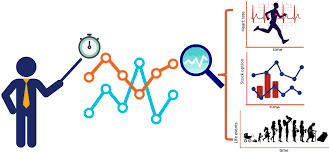

# Dự báo bán hàng

> Dự báo bán hàng là sự ước đoán về lượng bán của doanh nghiệp, (tính bằng tiền hoặc theo đơn vị sản phẩm) có thể bán được trong một thời kì nhất định dưới một kế hoạch marketing đã được thông qua và dưới một tổ hợp các điều kiện kinh tế được giả định


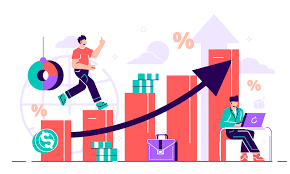


## mục tiêu
1. Phân tích dữ liệu chuỗi thời gian
2. Tìm ra ẩn thông tin từ data bằng cách sử dụng biểu đồ  
3. xây dụng mạng nơ-ron dự báo bán hàng


# Import thư viên 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter

# Mô tả tập dữ liệu 

<h2>Mô tả tệp</h2>
</p> --  sales_train.csv - bộ đào tạo. Dữ liệu lịch sử hàng ngày từ tháng 1 năm 2013 đến tháng 10 năm 2015.
</p> --  test.csv - bộ thử nghiệm. Bạn cần dự báo doanh thu cho các cửa hàng và sản phẩm này trong tháng 11 năm 2015.
</p> --  sample_submission.csv - tệp gửi mẫu ở định dạng chính xác.
</p> --  items.csv - thông tin bổ sung về các mặt hàng / sản phẩm.
</p> --item_categories.csv   - thông tin bổ sung về các danh mục mặt hàng.
</p> --Shop.csv - thông tin bổ sung về các cửa hàng.
<h2>Các trường dữ liệu</h2>
</p> *  ID  - một Id đại diện cho một bộ (Cửa hàng, Mặt hàng) trong bộ thử nghiệm
</p> *  shop_id - mã định danh duy nhất của một cửa hàng
</p> *  item_id - mã định danh duy nhất của một sản phẩm
</p> *  item_category_id - mã định danh duy nhất của danh mục mặt hàng
</p> *  item_cnt_day - số lượng sản phẩm đã bán. Bạn đang dự đoán số tiền hàng tháng của biện pháp này
</p> *  item_price - giá hiện tại của một mặt hàng
</p> *  date  - ngày ở định dạng dd / mm / yyyy
</p> *  date_block_num - một số tháng liên tiếp, được sử dụng để thuận tiện. Tháng 1 năm 2013 là 0, tháng 2 năm 2013 là 1, ..., tháng 10 năm 2015 là 33
</p> *  item_name  - tên của item
</p> *  shop_name - tên cửa hàng
</p> *  item_category_name - tên của danh mục mặt hàng

<h2> load data từ google drive</h2>

In [2]:
# !ls /content/drive/MyDrive/colab
#load data từ google drive
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)
path = "data"
item_categories = pd.read_csv(path+'/item_categories.csv')
items = pd.read_csv(path+'/items.csv')
sample_submission = pd.read_csv(path+'/sample_submission.csv')
sample_submission1 = pd.read_csv(path+'/sample_submission1.csv')
shops = pd.read_csv(path+'/shops.csv')
test = pd.read_csv(path+'/test.csv')
test1 = pd.read_csv(path+'/test1.csv')
train = pd.read_csv(path+'/train.csv')
sales_train = pd.read_csv(path+'/sales_train.csv')

In [3]:
print('item_categories')
print(item_categories.head())

print('items')
print(items.head())

print('sample_submission')
print(sample_submission.head())

print('sample_submission1')
print(sample_submission1.head())

print('shops')
print(shops.head())

print('test')
print(test.head())

print('test1')
print(test1.head())

print('train')
print(train.head())

print('sales_train')
print(sales_train.head())

item_categories
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
items
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
sample_submission
   ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5
sample_submission1
   id  sales
0  

<h3> Kết luận </h3>
<p> tất cả dữ liệu của hàng đều không có giá trị null</p>
<p> có của 60 hàng </p>
<p> có 22170 mặt hàng </p>
<p> Mỗi mặt hàng thuộc một trong 84 loại. </p>

## Phân tích data


##<h3> Gộp tập dữ liệu </h3>

In [4]:
# gộp tập item_categories và item 
item=pd.merge(item_categories,items, how='inner')
# gộp tập sales_train và shop
sales_train_shop=pd.merge(sales_train,shops,on='shop_id')

In [5]:
# gộp tổng hai ập mới item và sales_train_merged
df = pd.merge(sales_train_shop,item,on='item_id')
# xem thông tin 5 dòng đầu 
df.head().style.background_gradient(cmap='Blues').set_properties(**{'font-family': 'Segoe UI'})

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name
0,02.01.2013,0,59,22154,999.000000,1.000000,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD)
1,02.01.2013,0,25,22154,999.000000,1.000000,"Москва ТРК ""Атриум""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD)
2,03.01.2013,0,25,22154,999.000000,1.000000,"Москва ТРК ""Атриум""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD)
3,20.01.2013,0,25,22154,999.000000,1.000000,"Москва ТРК ""Атриум""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD)
4,23.01.2013,0,25,22154,999.000000,1.000000,"Москва ТРК ""Атриум""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD)


In [6]:
# thông tin của data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   shop_name           object 
 7   item_category_name  object 
 8   item_category_id    int64  
 9   item_name           object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


In [7]:
# giá trị của data
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In [8]:
# xem các giá trị null
df.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_category_name    0
item_category_id      0
item_name             0
dtype: int64

### <h3> Chuyển cột date (obj) thành datetime </h3>

In [9]:
# chuyển date( object ) thành date( datetime )
# phân tích cú pháp ngày với ngày đầu tiên, ví dụ: "10/11/12" được phân tích cú pháp là 2012-11-10
df.date = pd.to_datetime(df.date, dayfirst=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   shop_name           object        
 7   item_category_name  object        
 8   item_category_id    int64         
 9   item_name           object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 246.4+ MB
None


In [10]:
# thêm cột năm từ côt date
df['year'] = pd.to_datetime(df['date']).dt.strftime('%Y')
# thêm cột tháng  từ côt date
df['month'] = pd.to_datetime(df['date']).dt.strftime('%m')
# thêm cột này từ cột date
#df['day'] = pd.to_datetime(df['date']).dt.strftime('%d')
#df

# Trực quan hóa data

## Thống kê dữ liệu

In [11]:
# thống kê mô tả tập dữ liệu 
df.describe().style.background_gradient()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000
mean,14.569911,33.001728,10197.227057,890.853233,1.242641,40.001383
std,9.422988,16.226973,6324.297354,1729.799631,2.618834,17.100759
min,0.000000,0.000000,0.000000,-1.000000,-22.000000,0.000000
25%,7.000000,22.000000,4476.000000,249.000000,1.000000,28.000000
50%,14.000000,31.000000,9343.000000,399.000000,1.000000,40.000000
75%,23.000000,47.000000,15684.000000,999.000000,1.000000,55.000000
max,33.000000,59.000000,22169.000000,307980.000000,2169.000000,83.000000


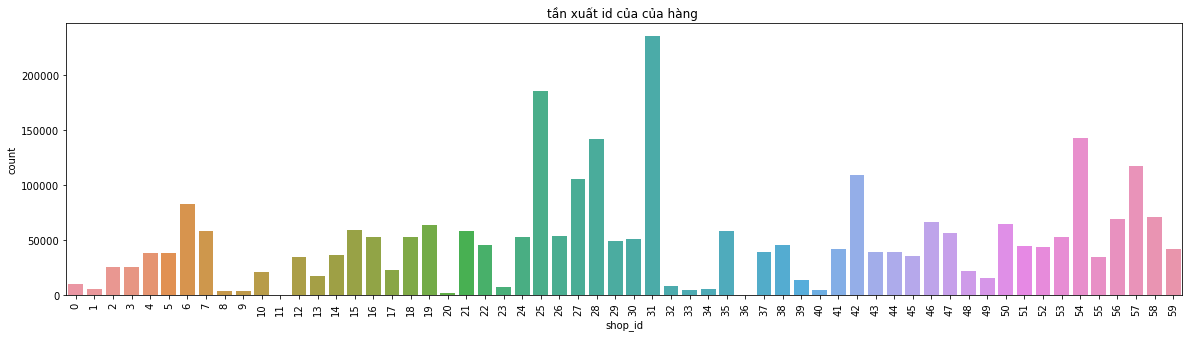

In [12]:
# số của hàng có lượng trao đổi mặt hàng 
plt.figure(figsize=(20,5))
#biểu đồ cột với x là shop và y là toongt số của hàng 
ax=sns.countplot(data=df, x='shop_id')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("tần xuất id của của hàng ")
plt.show()

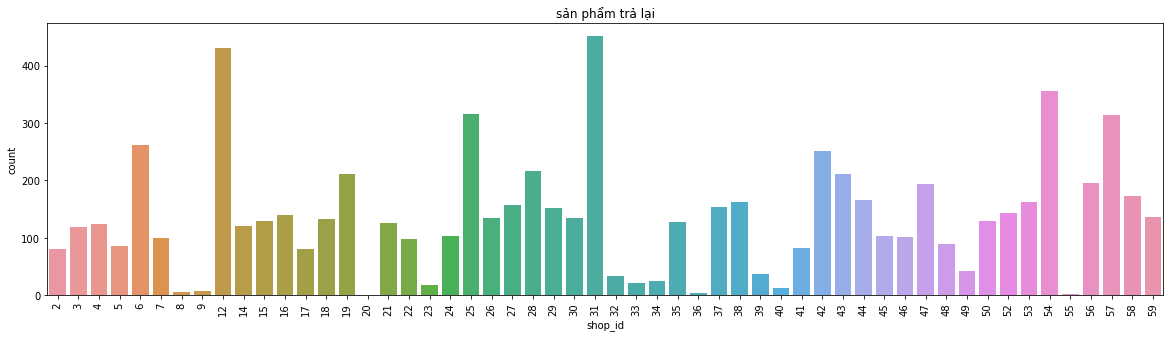

In [13]:
#số sản phẩm bị trả lại 
plt.figure(figsize=(20,5))
# shop và số sản phầm rả về 
ax=sns.countplot(data=df[df['item_cnt_day']<0], x='shop_id')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("sản phẩm trả lại")
plt.show()

In [14]:
# lọc sản phẩm theo shop_id.
df_shop31 = df.loc[df['shop_id']== 31]
#locid.describe().style.background_gradient()
df_shop31.head()
# Trung tâm mua sắm Moscow "Semenovsky"

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name,year,month
26,2013-01-05,0,31,22154,999.0,1.0,"Москва ТЦ ""Семеновский""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD),2013,01
27,2013-10-11,9,31,22154,999.0,1.0,"Москва ТЦ ""Семеновский""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD),2013,10
28,2013-12-31,11,31,22154,999.0,1.0,"Москва ТЦ ""Семеновский""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD),2013,12
29,2015-07-14,30,31,22154,299.0,1.0,"Москва ТЦ ""Семеновский""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD),2015,07
30,2015-08-03,31,31,22154,299.0,1.0,"Москва ТЦ ""Семеновский""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD),2015,08


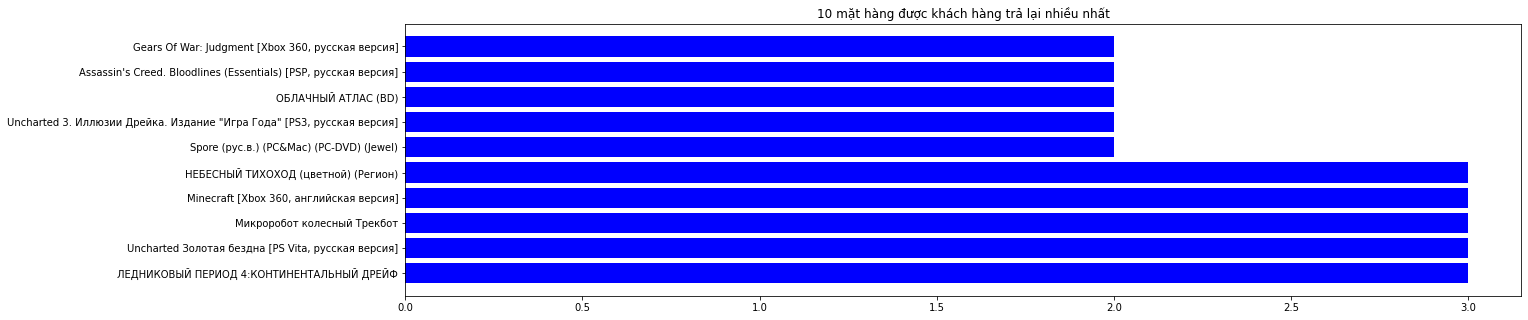

In [15]:
# sản phẩm được trả về nhiều nhất
# biến counter nhận giá trị số sản phẩm trả về
counter = pd.DataFrame(Counter(df_shop31[df_shop31['item_cnt_day']<0]['item_name']).most_common(10))
# lấy hai cột item_id và cột Counts
counter.columns=['item_name', 'Counts']
# ép cột item_id thành kiểu str
counter['item_name']=counter['item_name'].astype('str')
plt.figure(figsize=(20,5))
plt.barh(data=counter, y='item_name', width='Counts', color='blue')
plt.title("10 mặt hàng được khách hàng trả lại nhiều nhất")
plt.show()

In [16]:
# 3673 game Gears Of War
# 1523 game Assassin's
# 16451 phim CLOUD ATLAS (BD)
# 7218 game Illusion of Drake
# 6717 game Spore
# 15625 game SKY SLIDER
# 4870 game Minecraft
# 15106 game Trackbot
# 7220 game Uncharted Golden Abyss
# 13851 game lái xe cho trẻ 4 tuổi

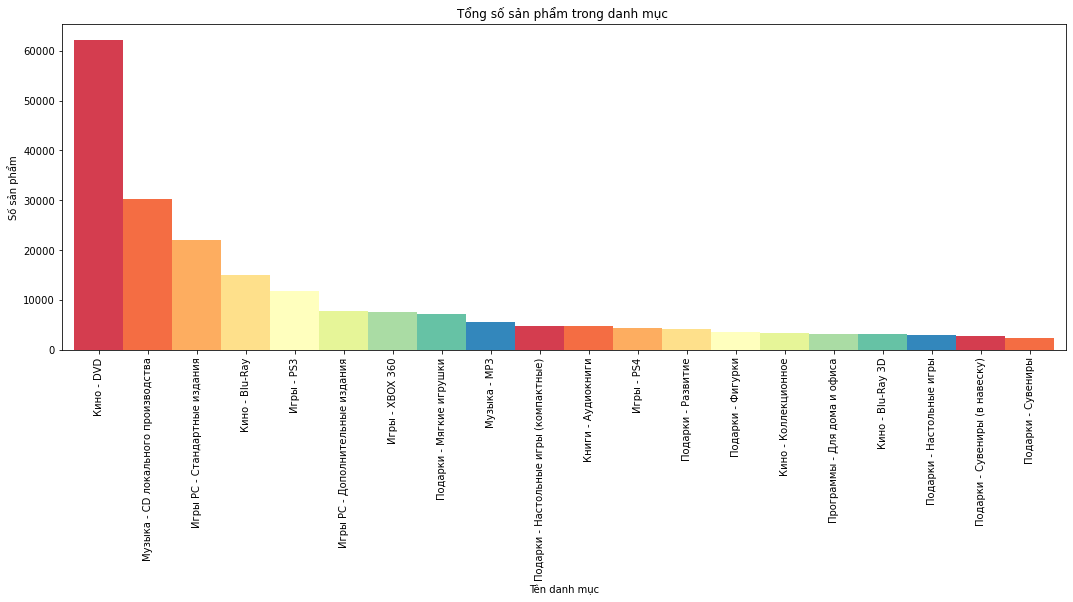

In [17]:
#số lượng mặt hàng trong danh mục 
# biến result nhận giá trị cột item_category_name
result=df_shop31['item_category_name'].value_counts().sort_values(ascending=False)[0:20]
# vẽ biểu đồ plot thanh dọc 'bar',kích thước ,độ dày cột và màu 
result.plot(kind='bar',figsize=(18,6),width =1,color=sns.color_palette("Spectral", 9))
# xét tên tiêu đề ,tên trục y,x
plt.title("Tổng số sản phẩm trong danh mục ")
plt.ylabel('Số sản phẩm')
plt.xlabel('Tên danh mục')
plt.show()

📈 Tổng số sản phẩm nhiều nhất ở mặt hàng DVD <p>
Sản phẩm ít nhất ở 20 mặt hàng Quà tặng quà lưu niệm 

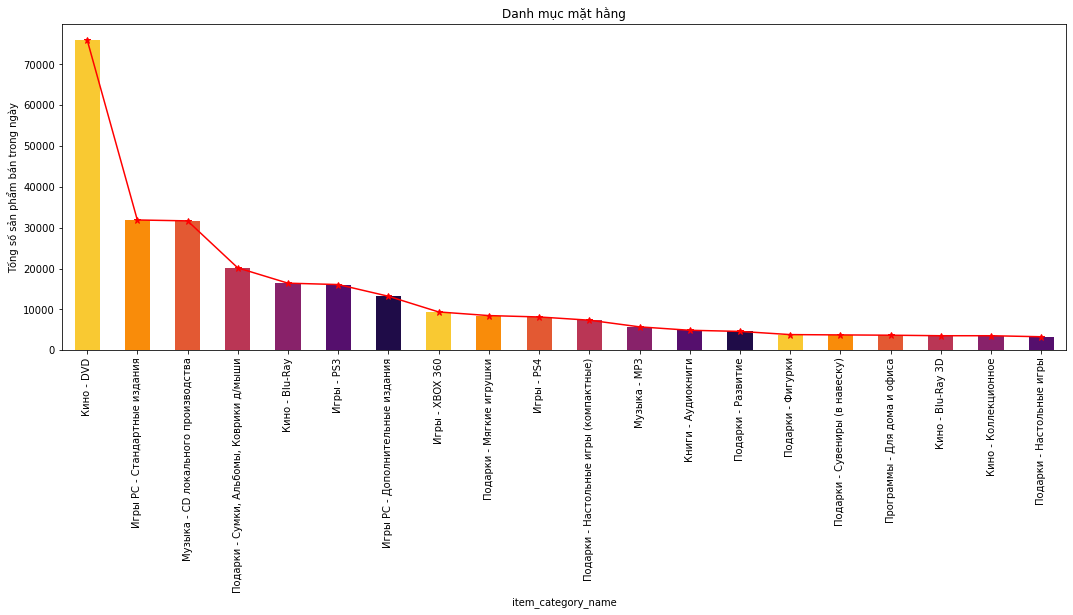

In [18]:
# số sản phẩm đã bán trong mỗi danh mục mặt hàng
plt.figure(figsize=(18,6))
plt.title('Danh mục mặt hằng')
plt.ylabel('Tống số sản phẩm bán trong ngày')
# giá trị giao nhau=*,ms là độ dày giá trị giao nhau.
df_shop31.groupby('item_category_name')['item_cnt_day'].sum().sort_values(ascending=False)[0:20].plot(kind='line', marker='*', color='red', ms=7)
df_shop31.groupby('item_category_name')['item_cnt_day'].sum().sort_values(ascending=False)[0:20].plot(kind='bar',color=sns.color_palette("inferno_r", 7))
plt.show()

📈 số sản phẩm bán ra nhiều nhất ở danh mục DVD <p>
Sản phẩm bán ra ít nhất ở các mục Quà tặng -đồ trơi trên bàn

In [19]:
df_DVD =  df_shop31.loc[df_shop31['item_category_id']== 40]
df_DVD

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name,year,month
212,2013-01-06,0,31,22151,399.0,2.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,ЯВЛЕНИЕ (2012),2013,01
213,2013-01-05,0,31,22151,399.0,2.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,ЯВЛЕНИЕ (2012),2013,01
214,2013-01-04,0,31,22151,399.0,6.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,ЯВЛЕНИЕ (2012),2013,01
215,2013-01-03,0,31,22151,399.0,3.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,ЯВЛЕНИЕ (2012),2013,01
216,2013-01-02,0,31,22151,399.0,2.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,ЯВЛЕНИЕ (2012),2013,01
...,...,...,...,...,...,...,...,...,...,...,...,...
2899390,2015-10-04,33,31,17440,249.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,ПРИХОДИТЕ ЗАВТРА (rem),2015,10
2899400,2015-10-30,33,31,18530,249.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,СВАДЬБА В МАЛИНОВКЕ (rem),2015,10
2899426,2015-10-16,33,31,17902,98.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,РОБОТЫ (ХХкатА),2015,10
2899449,2015-10-22,33,31,10062,28.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,ВРЕМЕННО БЕРЕМЕННА,2015,10


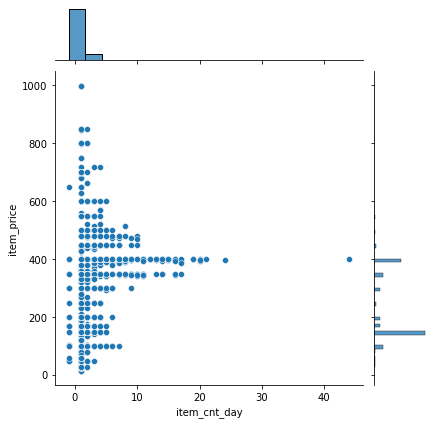

In [20]:
#sns.jointplot(x="item_cnt_day", y="item_price", data=df, height=8)
sns.jointplot(data=df_DVD, x="item_cnt_day", y="item_price")
plt.show()

In [21]:
print('giá trước khi lấy:', df_DVD.shape)
#lấy tất cả giá lớn hơn không
df = df_DVD.query('item_price > 0')
print('giá sau khi lấy:', df_DVD.shape)
#loại bỏ giá trị trùng lặp
print('Tệp dữ liệu trước khi lọc :', df_DVD.shape)
df = df_DVD[df_DVD['shop_id'].isin(df_DVD['shop_id'].unique())]

df = df_DVD[df_DVD['item_id'].isin(df_DVD['item_id'].unique())]
print('Tệp dữ liệu sau khi lọc:', df.shape)

print('trước khi loại bỏ out line:', df.shape)
# lấy giá trị số sản phẩm bán và giá nhỏ hơn 75000
df = df.query('item_cnt_day >= 0 and item_cnt_day <= 30 and item_price < 900')
print('sau khi loại bỏ out line:', df.shape)

giá trước khi lấy: (62235, 12)
giá sau khi lấy: (62235, 12)
Tệp dữ liệu trước khi lọc : (62235, 12)
Tệp dữ liệu sau khi lọc: (62235, 12)
trước khi loại bỏ out line: (62235, 12)
sau khi loại bỏ out line: (62148, 12)


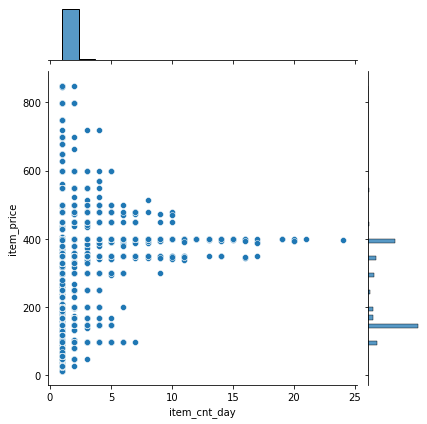

In [22]:
#sns.jointplot(x="item_cnt_day", y="item_price", data=df, height=8)
sns.jointplot(data=df, x="item_cnt_day", y="item_price")
plt.show()

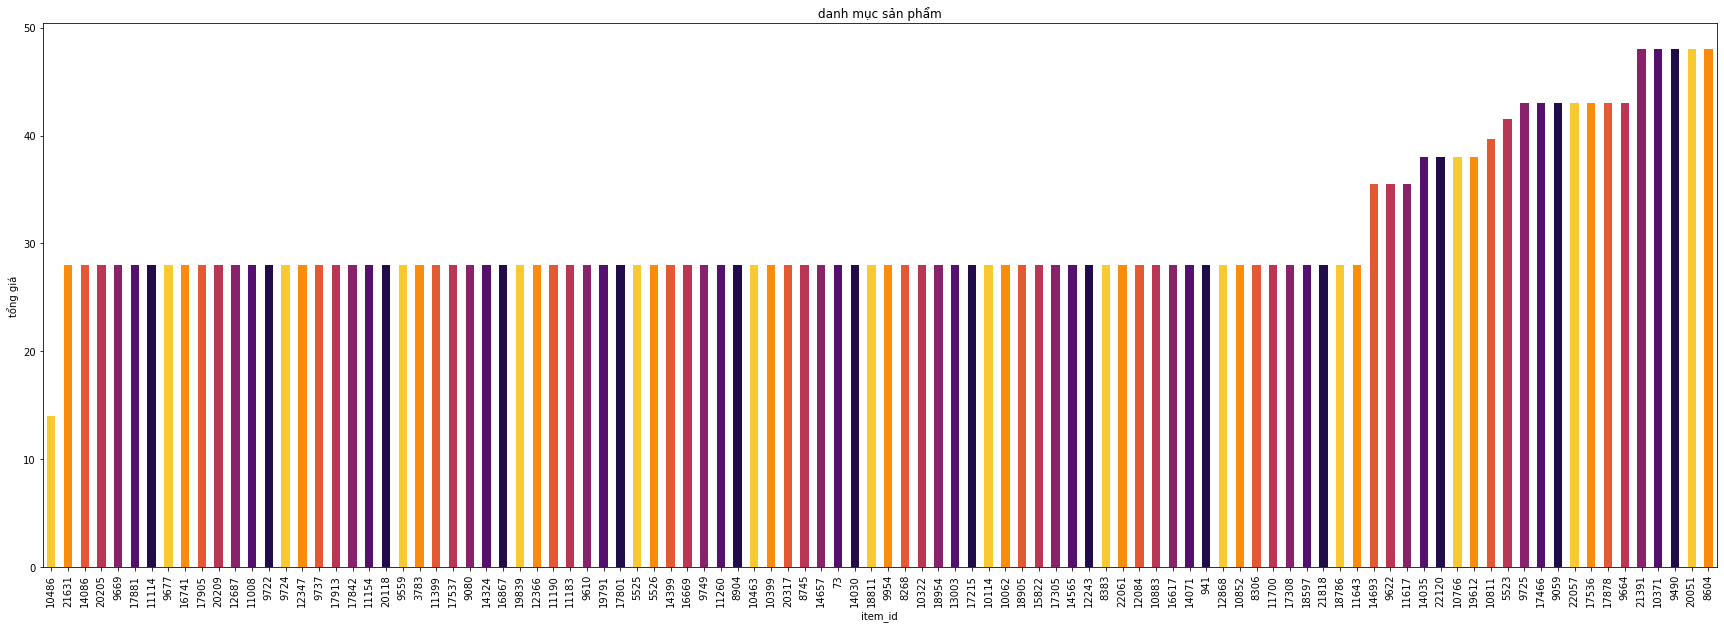

In [23]:
# giá của các mặt hàng nhỏ hơn 100 
plt.figure(figsize=(30,10))
plt.title('danh mục sản phẩm')
plt.ylabel('tổng giá')
# sắp xếp dữ liệu, nhóm danh mục và giá theo trung bình
#df_DVD.groupby('item_id')['item_price'].mean().sort_values(ascending=True)[0:].plot(kind='line', marker='*', color='red', ms=10)
df.groupby('item_id')['item_price'].mean().sort_values(ascending=True)[:100].plot(kind='bar',color=sns.color_palette("inferno_r", 7))
plt.show()

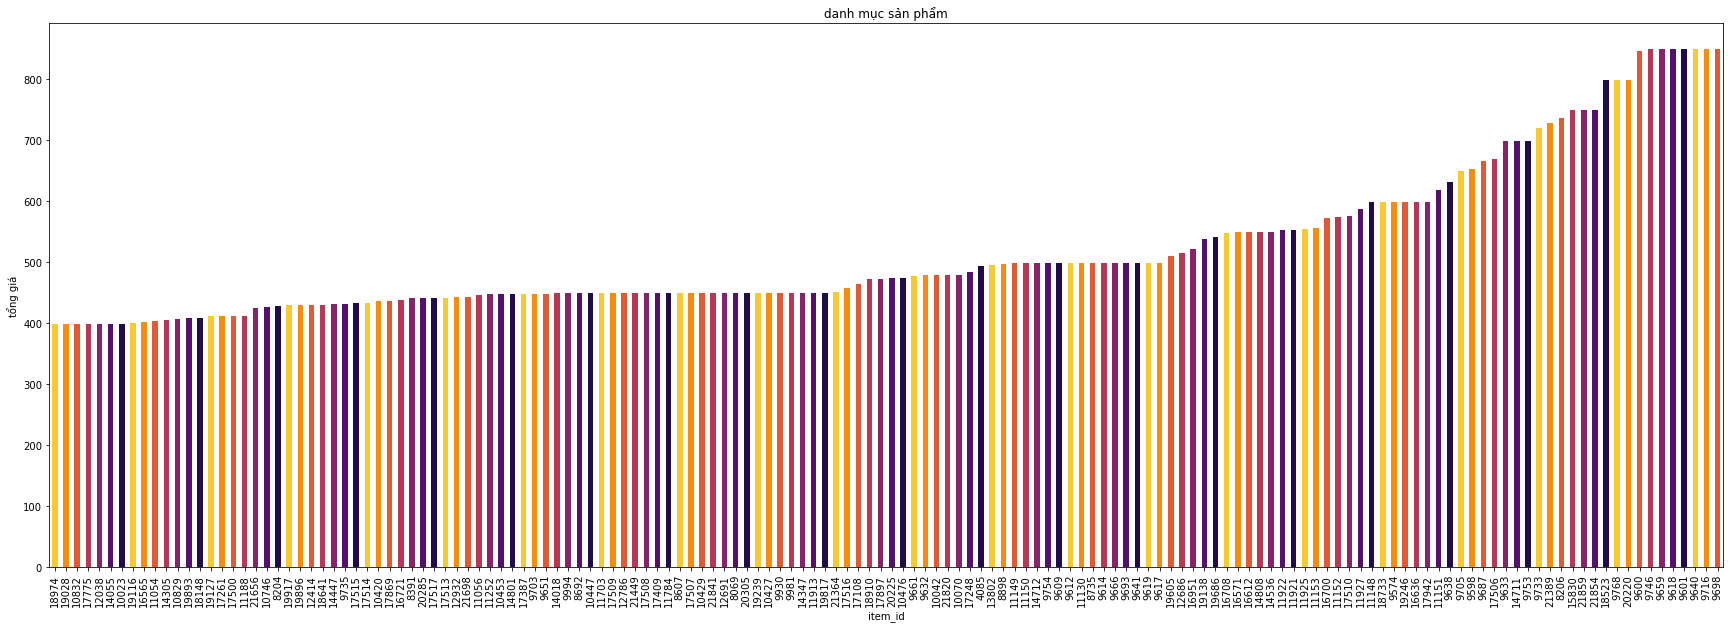

In [24]:
# giá của các mặt hàng
plt.figure(figsize=(30,10))
plt.title('danh mục sản phẩm')
plt.ylabel('tổng giá')
# sắp xếp dữ liệu, nhóm danh mục và giá theo trung bình
#df_DVD.groupby('item_id')['item_price'].mean().sort_values(ascending=True)[0:].plot(kind='line', marker='*', color='red', ms=10)
df.groupby('item_id')['item_price'].mean().sort_values(ascending=True)[4000:].plot(kind='bar',color=sns.color_palette("inferno_r", 7))
plt.show()

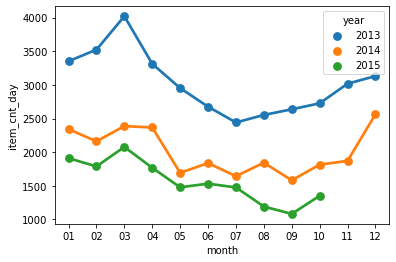

In [25]:
# biểu đồ tỉ lệ số lượng sản phẩm đã bán và tháng
#Đặt lại chỉ mục, nhóm năm tháng theo tổng số sản phẩm bán ra 
grouped = pd.DataFrame(df.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year',gird=True ,data=grouped);

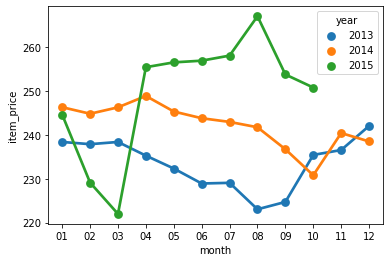

In [26]:
# biểu đồ tỉ lệ giá bán và tháng
grouped_price = pd.DataFrame(df.groupby(['year','month'])['item_price'].mean().reset_index())
sns.pointplot(x='month', y='item_price', hue='year',gird=True, data=grouped_price);

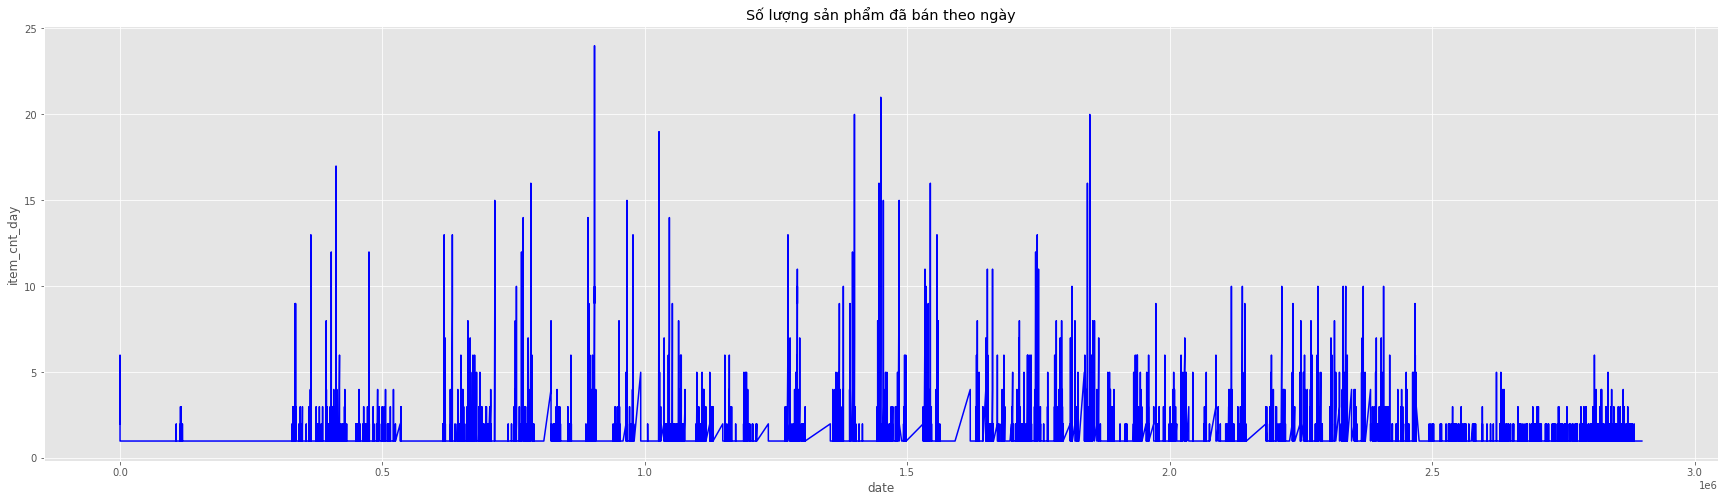

In [27]:
# sử dụng biểu đồ ggplot
plt.style.use('ggplot')
ax2 = df['item_cnt_day'].plot(figsize=(30,8),color='blue')
# đặt tên title 
ax2.set_title('Số lượng sản phẩm đã bán theo ngày');
# sét trục x đặt tên là date
ax2.set_xlabel('date')
# xét trục y là item_cnt_day
ax2.set_ylabel('item_cnt_day')
plt.show()

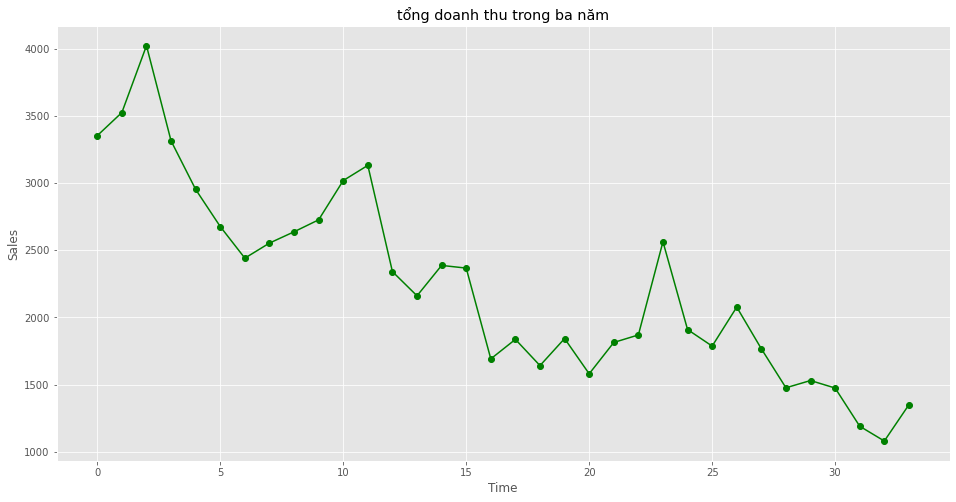

In [28]:
# biểu đồ tổng doanh thu trong ba năm
ts=df.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('tổng doanh thu trong ba năm')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.grid(True)
plt.plot(ts,'go-')
plt.show()

In [60]:
# Nhóm dập dữ liệu theo hàng tháng 
monthly_df=df.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})
monthly_df.head()
# trong tập dữ liệu này sẽ nhóm tháng và shop bán sản phẩm đó trong khoảng ngày và giá trung bình, tổng số sản phẩm bán được trong ngày .

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1712\1917191200.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthly_df=df.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})


date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              31      32      2013-01-02 2013-01-31      349.0         24.0
                       35      2013-01-23 2013-01-30      399.0          5.0
                       72      2013-01-14 2013-01-14      119.0          1.0
                       75      2013-01-10 2013-01-10      149.0          1.0
                       94      2013-01-13 2013-01-13      299.0          1.0

In [63]:
sales = df.groupby(["date_block_num","shop_id","item_id"])[['date_block_num','date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']].agg({"date_block_num":'mean',"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})
sales

date_block_num       date             \
                                         mean        min        max   
date_block_num shop_id item_id                                        
0              31      32                 0.0 2013-01-02 2013-01-31   
                       35                 0.0 2013-01-23 2013-01-30   
                       72                 0.0 2013-01-14 2013-01-14   
                       75                 0.0 2013-01-10 2013-01-10   
                       94                 0.0 2013-01-13 2013-01-13   
...                                       ...        ...        ...   
33             31      22051             33.0 2015-10-25 2015-10-25   
                       22058             33.0 2015-10-27 2015-10-27   
                       22072             33.0 2015-10-14 2015-10-14   
                       22162             33.0 2015-10-09 2015-10-09   
                       22163             33.0 2015-10-02 2015-10-25   

                               item_price item_cnt_day  
                                     mean          sum  
date_block_num shop_id item_id                          
0              31      32           349.0         24.0  
                       35           399.0          5.0  
                       72           119.0          1.0  
                       75           149.0          1.0  
                       94           299.0          1.0  
...                                   ...          ...  
33             31      22051        399.0          1.0  
                       22058        129.0          1.0  
                       22072        198.0          1.0  
                       22162        349.0          1.0  
                       22163        169.0          6.0  

[26537 rows x 5 columns]

In [64]:
monthly_sales=df.groupby(["date_block_num","shop_id","item_id"])[
    "date_block_num","date","item_price","item_cnt_day"].agg({"date_block_num":'mean',"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

monthly_sales

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1712\1453980068.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthly_sales=df.groupby(["date_block_num","shop_id","item_id"])[


date_block_num       date             \
                                         mean        min        max   
date_block_num shop_id item_id                                        
0              31      32                 0.0 2013-01-02 2013-01-31   
                       35                 0.0 2013-01-23 2013-01-30   
                       72                 0.0 2013-01-14 2013-01-14   
                       75                 0.0 2013-01-10 2013-01-10   
                       94                 0.0 2013-01-13 2013-01-13   
...                                       ...        ...        ...   
33             31      22051             33.0 2015-10-25 2015-10-25   
                       22058             33.0 2015-10-27 2015-10-27   
                       22072             33.0 2015-10-14 2015-10-14   
                       22162             33.0 2015-10-09 2015-10-09   
                       22163             33.0 2015-10-02 2015-10-25   

                               item_price item_cnt_day  
                                     mean          sum  
date_block_num shop_id item_id                          
0              31      32           349.0         24.0  
                       35           399.0          5.0  
                       72           119.0          1.0  
                       75           149.0          1.0  
                       94           299.0          1.0  
...                                   ...          ...  
33             31      22051        399.0          1.0  
                       22058        129.0          1.0  
                       22072        198.0          1.0  
                       22162        349.0          1.0  
                       22163        169.0          6.0  

[26537 rows x 5 columns]

In [66]:
monthly_data = df.pivot_table(
    index = ['shop_id','item_id'],
    values = ['item_cnt_day'],
    columns = ['date_block_num'],
    fill_value = 0,
    aggfunc='sum')

monthly_data

item_cnt_day                                    ...          \
date_block_num            0    1   2   3   4   5   6  7  8  9   ...  24  25   
shop_id item_id                                                 ...           
31      26                 0    0   0   0   0   0   0  0  0  0  ...   0   0   
        30                 0  112  65  13  10   3   4  1  4  2  ...   1   1   
        32                24   20  13  11   6  11  10  9  2  7  ...  11   5   
        34                 0    1   1   2   0   1   0  1  0  1  ...   0   0   
        35                 5    4   2   0   0   0   0  0  0  0  ...   0   0   
...                      ...  ...  ..  ..  ..  ..  .. .. .. ..  ...  ..  ..   
        22152              0    0   0   5   0   1   1  0  0  0  ...   0   0   
        22159              0    0   0   0   0   0   0  0  0  0  ...   0   0   
        22160              1    2   2   0   1   2   0  1  1  0  ...   0   0   
        22162              0    0   0   0   0   0   0  0  0  0  ...   0  32   
        22163              0    0   0   0   0   0   0  0  0  0  ...   0   0   

                                          
date_block_num   26 27 28 29 30 31 32 33  
shop_id item_id                           
31      26        0  0  0  0  0  0  0  0  
        30        1  0  0  0  0  0  0  1  
        32       10  2  3  6  5  5  3  3  
        34        0  0  0  0  0  0  0  0  
        35        0  0  0  0  0  0  0  0  
...              .. .. .. .. .. .. .. ..  
        22152     0  0  0  0  0  0  0  0  
        22159     0  0  3  1  0  0  0  0  
        22160     0  0  0  0  0  0  0  0  
        22162    25  7  2  4  4  5  0  1  
        22163     0  0  0  0  0  8  5  6  

[4150 rows x 34 columns]

In [68]:
monthly_data = df.pivot_table(
    index = ['shop_id','item_id'],
    values = ['item_cnt_day'],
    columns = ['date_block_num'],
    fill_value = 0,
    aggfunc='sum')

monthly_data

item_cnt_day                                    ...          \
date_block_num            0    1   2   3   4   5   6  7  8  9   ...  24  25   
shop_id item_id                                                 ...           
31      26                 0    0   0   0   0   0   0  0  0  0  ...   0   0   
        30                 0  112  65  13  10   3   4  1  4  2  ...   1   1   
        32                24   20  13  11   6  11  10  9  2  7  ...  11   5   
        34                 0    1   1   2   0   1   0  1  0  1  ...   0   0   
        35                 5    4   2   0   0   0   0  0  0  0  ...   0   0   
...                      ...  ...  ..  ..  ..  ..  .. .. .. ..  ...  ..  ..   
        22152              0    0   0   5   0   1   1  0  0  0  ...   0   0   
        22159              0    0   0   0   0   0   0  0  0  0  ...   0   0   
        22160              1    2   2   0   1   2   0  1  1  0  ...   0   0   
        22162              0    0   0   0   0   0   0  0  0  0  ...   0  32   
        22163              0    0   0   0   0   0   0  0  0  0  ...   0   0   

                                          
date_block_num   26 27 28 29 30 31 32 33  
shop_id item_id                           
31      26        0  0  0  0  0  0  0  0  
        30        1  0  0  0  0  0  0  1  
        32       10  2  3  6  5  5  3  3  
        34        0  0  0  0  0  0  0  0  
        35        0  0  0  0  0  0  0  0  
...              .. .. .. .. .. .. .. ..  
        22152     0  0  0  0  0  0  0  0  
        22159     0  0  3  1  0  0  0  0  
        22160     0  0  0  0  0  0  0  0  
        22162    25  7  2  4  4  5  0  1  
        22163     0  0  0  0  0  8  5  6  

[4150 rows x 34 columns]

In [72]:
dataset = df.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')
dataset

item_cnt_day                                    ...          \
date_block_num            0    1   2   3   4   5   6  7  8  9   ...  24  25   
shop_id item_id                                                 ...           
31      26                 0    0   0   0   0   0   0  0  0  0  ...   0   0   
        30                 0  112  65  13  10   3   4  1  4  2  ...   1   1   
        32                24   20  13  11   6  11  10  9  2  7  ...  11   5   
        34                 0    1   1   2   0   1   0  1  0  1  ...   0   0   
        35                 5    4   2   0   0   0   0  0  0  0  ...   0   0   
...                      ...  ...  ..  ..  ..  ..  .. .. .. ..  ...  ..  ..   
        22152              0    0   0   5   0   1   1  0  0  0  ...   0   0   
        22159              0    0   0   0   0   0   0  0  0  0  ...   0   0   
        22160              1    2   2   0   1   2   0  1  1  0  ...   0   0   
        22162              0    0   0   0   0   0   0  0  0  0  ...   0  32   
        22163              0    0   0   0   0   0   0  0  0  0  ...   0   0   

                                          
date_block_num   26 27 28 29 30 31 32 33  
shop_id item_id                           
31      26        0  0  0  0  0  0  0  0  
        30        1  0  0  0  0  0  0  1  
        32       10  2  3  6  5  5  3  3  
        34        0  0  0  0  0  0  0  0  
        35        0  0  0  0  0  0  0  0  
...              .. .. .. .. .. .. .. ..  
        22152     0  0  0  0  0  0  0  0  
        22159     0  0  3  1  0  0  0  0  
        22160     0  0  0  0  0  0  0  0  
        22162    25  7  2  4  4  5  0  1  
        22163     0  0  0  0  0  8  5  6  

[4150 rows x 34 columns]

#Xử lý dữ liệu 


In [30]:
df31_53 = df.loc[df['item_id']== 35]
df31_53

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name,year,month
533915,2013-01-30,0,31,35,399.0,2.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,10 ЛЕТ СПУСТЯ,2013,01
533916,2013-01-25,0,31,35,399.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,10 ЛЕТ СПУСТЯ,2013,01
533917,2013-01-23,0,31,35,399.0,2.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,10 ЛЕТ СПУСТЯ,2013,01
533918,2013-02-02,1,31,35,399.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,10 ЛЕТ СПУСТЯ,2013,02
533919,2013-02-09,1,31,35,399.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,10 ЛЕТ СПУСТЯ,2013,02
533920,2013-02-18,1,31,35,399.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,10 ЛЕТ СПУСТЯ,2013,02
533921,2013-02-23,1,31,35,399.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,10 ЛЕТ СПУСТЯ,2013,02
533922,2013-03-27,2,31,35,399.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,10 ЛЕТ СПУСТЯ,2013,03
533923,2013-03-01,2,31,35,399.0,1.0,"Москва ТЦ ""Семеновский""",Кино - DVD,40,10 ЛЕТ СПУСТЯ,2013,03


In [31]:
# từ tập trên ta rút ra tập dữ liệu với các tháng ,tên shop , tên sản phẩm và số sản phẩm bán ra 
sales_forecast = monthly_df.item_cnt_day.apply(list).reset_index()
sales_forecast["id"]=pd.DataFrame(sales_forecast.index)
sales_forecast

,date_block_num,shop_id,item_id,sum,id
0,0,31,32,24.0,0
1,0,31,35,5.0,1
2,0,31,72,1.0,2
3,0,31,75,1.0,3
4,0,31,94,1.0,4
...,...,...,...,...,...
26532,33,31,22051,1.0,26532
26533,33,31,22058,1.0,26533
26534,33,31,22072,1.0,26534
26535,33,31,22162,1.0,26535


In [32]:
#thay nan =0
#sales_forecast.fillna(0,inplace = True)
# xóa cột shop_id và item_id
sales_forecast.drop(['shop_id','item_id'],inplace = True, axis = 1)
sales_forecast

,date_block_num,sum,id
0,0,24.0,0
1,0,5.0,1
2,0,1.0,2
3,0,1.0,3
4,0,1.0,4
...,...,...,...
26532,33,1.0,26532
26533,33,1.0,26533
26534,33,1.0,26534
26535,33,1.0,26535


In [33]:
# tạo bảng dữ liệu với  id và date_block_num với các mục là sản phẩm bán được.
pivoted_sales = sales_forecast.pivot_table(index="id",columns='date_block_num',fill_value = 0,aggfunc='sum')
pivoted_sales

sum                             ...                             \
date_block_num  0  1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28 29 30 31 32   
id                                             ...                              
0               24  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
1                5  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
2                1  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
3                1  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
4                1  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
...             .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. ..   
26532            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
26533            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
26534            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
26535            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
26536            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   

                   
date_block_num 33  
id                 
0               0  
1               0  
2               0  
3               0  
4               0  
...            ..  
26532           1  
26533           1  
26534           1  
26535           1  
26536           6  

[26537 rows x 34 columns]

In [34]:
#tách tập train và test
X_train = np.expand_dims(pivoted_sales.values[:,:-1],axis = 2)
y_train = pivoted_sales.values[:,-1:]
X_test = np.expand_dims(pivoted_sales.values[:,1:],axis = 2)

#X_train = pivoted_sales.values[:,:-1]
#y_train = pivoted_sales.values[:,-1:]
#X_test = pivoted_sales.values[:,1:]

In [35]:
#X_train

# Xây dựng mạng nơ-ron

<h2> LSTM là gì </h2>

In [36]:
# import thư viện
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Bidirectional,Embedding
from keras.models import load_model, Model

In [37]:
# Xây dựng mạng nơ-ron đơn giản
model_lstm = Sequential()
#Xây dungje lớp mạng nơ-ron LSTM với số chiều là 64
model_lstm.add(LSTM(64,input_shape =(33,1)))
# dropout trách việc học tủ của mạng 
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16))

model_lstm.compile(loss = 'mse', metrics = ['mean_squared_error'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
Total params: 17,936
Trainable params: 17,936
Non-trainable params: 0
_________________________________________________________________


In [38]:

model_lstm.fit(X_train,y_train, batch_size = 4096,epochs = 2)

Epoch 1/2
7/7 [==============================] - 7s 554ms/step - loss: 0.3227 - mean_squared_error: 0.3227
Epoch 2/2
7/7 [==============================] - 4s 548ms/step - loss: 0.3187 - mean_squared_error: 0.3187


# Tinh chỉnh tham số 

In [39]:
# Xây dựng mạng nơ-ron đơn giản
model_lstm1 = Sequential()
#Xây dựng lớp mạng nơ-ron LSTM với số chiều là 64
model_lstm1.add(LSTM(64,return_sequences=True,input_shape =(33,1)))
#Xây dựng lớp mạng nơ-ron LSTM với số chiều là 32
model_lstm1.add(LSTM(32))
# dropout trách việc học tủ của mạng 
model_lstm1.add(Dropout(0.2))
# đầu ra của mạng sẽ là 16
model_lstm1.add(Dense(16))
# đầu ra của mạng sẽ là 1
model_lstm1.add(Dense(1))

# trả về kết quả xây dụng ,tính toán mạng nơ-ron
model_lstm1.compile(loss = 'mse', metrics = [['acc'],['mean_squared_error']])
# thông tin của mạng.
model_lstm1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 33, 64)            16896     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_lstm1.fit(X_train,y_train, batch_size = 4096,epochs = 2)

Epoch 1/2
7/7 [==============================] - 12s 1s/step - loss: 0.3216 - acc: 0.9804 - mean_squared_error: 0.3216
Epoch 2/2
7/7 [==============================] - 7s 961ms/step - loss: 0.3181 - acc: 0.9804 - mean_squared_error: 0.3181


<h3> Tăng số chiều của thuật toán </h3>

In [41]:
# Xây dựng mạng nơ-ron đơn giản
model_lstm2 = Sequential()
#Xây dựng lớp mạng nơ-ron LSTM với số chiều là 128
model_lstm2.add(LSTM(128,return_sequences=True,input_shape =(33,1)))
#Xây dựng lớp mạng nơ-ron LSTM với số chiều là 64
model_lstm2.add(LSTM(64))
# dropout trách việc học tủ của mạng 
model_lstm2.add(Dropout(0.2))
model_lstm2.add(Dense(16))
model_lstm2.add(Dense(1))

model_lstm2.compile(loss = 'mse', metrics = [['acc'],['mean_squared_error']])
model_lstm2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 33, 128)           66560     
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 117,025
Trainable params: 117,025
Non-trainable params: 0
_________________________________________________________________


In [42]:
model_lstm2.fit(X_train,y_train, batch_size = 4096,epochs = 2)

Epoch 1/2
7/7 [==============================] - 20s 2s/step - loss: 0.3238 - acc: 0.9797 - mean_squared_error: 0.3238
Epoch 2/2
7/7 [==============================] - 17s 2s/step - loss: 0.3195 - acc: 0.9804 - mean_squared_error: 0.3195


<h2> Sử dụng trình tối ưu hóa cho mạng </h2>

In [43]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import Ftrl
from tensorflow.keras.optimizers import SGD

Adadelta: Trình tối ưu hóa triển khai thuật toán Adadelta.<p>
Adagrad: Trình tối ưu hóa triển khai thuật toán Adagrad.<p>
Adam: Trình tối ưu hóa thực hiện thuật toán Adam.<p>
Adamax: Trình tối ưu hóa triển khai thuật toán Adamax.<p>
Ftrl: Trình tối ưu hóa triển khai thuật toán FTRL.<p>
Nadam: Trình tối ưu hóa triển khai thuật toán NAdam.<p>
Lớp trình tối ưu hóa: Lớp cơ sở cho các trình tối ưu hóa Keras.<p>
RMSprop: Trình tối ưu hóa triển khai thuật toán RMSprop.<p>
SGD: Trình tối ưu hóa dốc xuống (có xung lượng).<p>

In [44]:
#adam =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
#model_lstm2.compile(loss = 'mse',optimizer = adam, metrics = ['mean_squared_error'])
#model_lstm2.summary()

In [45]:
#Adagrad1 = Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07,name="Adagrad")
#model_lstm2.compile(loss = 'mse',optimizer = Adagrad1, metrics = ['mean_squared_error'])
#model_lstm2.summary()

In [46]:
#RMSprop1= RMSprop(learning_rate=0.001,rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
#model_lstm2.compile(loss = 'mse',optimizer = RMSprop1, metrics = ['mean_squared_error'])
#model_lstm2.summary()

In [47]:
#Adadelta1=Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')
#model_lstm2.compile(loss = 'mse',optimizer = Adadelta1, metrics = ['mean_squared_error'])
#model_lstm2.summary()

In [48]:
#Adamax1=Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,name='Adamax')
#model_lstm2.compile(loss = 'mse',optimizer = Adamax1, metrics = ['mean_squared_error'])
#model_lstm2.summary()

In [49]:
#Nadam1=Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,name='Nadam')
#model_lstm2.compile(loss = 'mse',optimizer = Nadam1, metrics = ['mean_squared_error'])
#model_lstm2.summary()

In [50]:
#Ftrl1=Ftrl(learning_rate=0.001,learning_rate_power=-0.5,initial_accumulator_value=0.1,
#     l1_regularization_strength=0.0,l2_regularization_strength=0.0,name="Ftrl",
#     l2_shrinkage_regularization_strength=0.0,beta=0.0,)
#model_lstm2.compile(loss = 'mse',optimizer = Ftrl1, metrics = ['mean_squared_error'])
#model_lstm2.summary()

In [51]:
#SGD1=SGD(learning_rate=0.01,  momentum=0.0,  nesterov=False,  name="SGD", )
#model_lstm2.compile(loss = 'mse',optimizer = SGD1, metrics = ['mean_squared_error'])
#model_lstm2.summary()

# Mạng nơ-ron LSTM trong dự đoán

In [52]:
# Xây dựng mạng nơ-ron đơn giản
model_lstm3 = Sequential()
#Xây dựng lớp mạng nơ-ron LSTM với số chiều là 64
model_lstm3.add(LSTM(128,return_sequences=True,input_shape =(33,1)))
model_lstm3.add(LSTM(64))
# dropout trách việc học tủ của mạng 
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(16))
model_lstm3.add(Dense(1))

adam =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
model_lstm3.compile(loss = 'mse',optimizer = adam, metrics = ['mean_squared_error'])
model_lstm3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 33, 128)           66560     
                                                                 
 lstm_6 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 117,025
Trainable params: 117,025
Non-trainable params: 0
_________________________________________________________________


In [54]:
lstm_model = model_lstm3.fit(X_train,y_train,epochs = 20)

Epoch 1/20
830/830 [==============================] - 33s 40ms/step - loss: 0.1969 - mean_squared_error: 0.1969
Epoch 2/20
830/830 [==============================] - 35s 42ms/step - loss: 0.1955 - mean_squared_error: 0.1955
Epoch 3/20
830/830 [==============================] - 33s 40ms/step - loss: 0.1971 - mean_squared_error: 0.1971
Epoch 4/20
830/830 [==============================] - 33s 39ms/step - loss: 0.1964 - mean_squared_error: 0.1964
Epoch 5/20
830/830 [==============================] - 33s 40ms/step - loss: 0.1987 - mean_squared_error: 0.1987
Epoch 6/20
830/830 [==============================] - 35s 42ms/step - loss: 0.1975 - mean_squared_error: 0.1975
Epoch 7/20
830/830 [==============================] - 35s 42ms/step - loss: 0.1946 - mean_squared_error: 0.1946
Epoch 8/20
830/830 [==============================] - 35s 42ms/step - loss: 0.1955 - mean_squared_error: 0.1955
Epoch 9/20
830/830 [==============================] - 34s 41ms/step - loss: 0.1987 - mean_squared_error:

In [55]:
# đặt biến df_his1 lấy giá lịch sử chạy của model làm data
df_his1 = pd.DataFrame(lstm_model.history)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


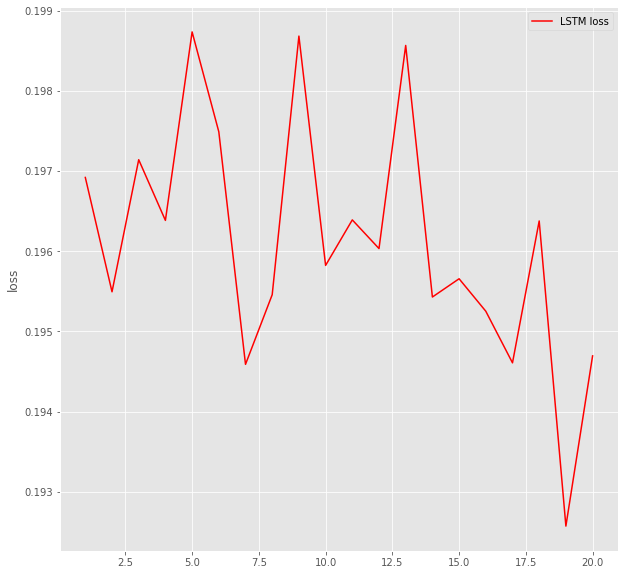

In [56]:
# vẽ biểu đồ chực qua hóa kết quả chạy với x là số lần chạy và y là số loss 
plt.figure(figsize = (10 , 10))
plt.legend(loc='best')
sns.lineplot(x= df_his1.index + 1, y = df_his1['loss'], color='r', label="LSTM loss");


In [57]:

submission_output = model_lstm3.predict(X_test)
# creating dataframe with required columns 
#submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':submission_output.ravel()}).round(0)
submission = pd.DataFrame({'ID':pivoted_sales.index,'item_cnt_month':submission_output.ravel()})
#submission = pd.DataFrame({'ID':sales_data_flat["item_id"]})
# creating csv file from dataframe
#submission.to_csv('submission.csv',index = False)
submission.to_csv('submission_stacked.csv',index = False)
submission.head()

830/830 [==============================] - 18s 20ms/step


,ID,item_cnt_month
0,0,2.602656
1,1,2.602656
2,2,2.602656
3,3,2.602656
4,4,2.602656


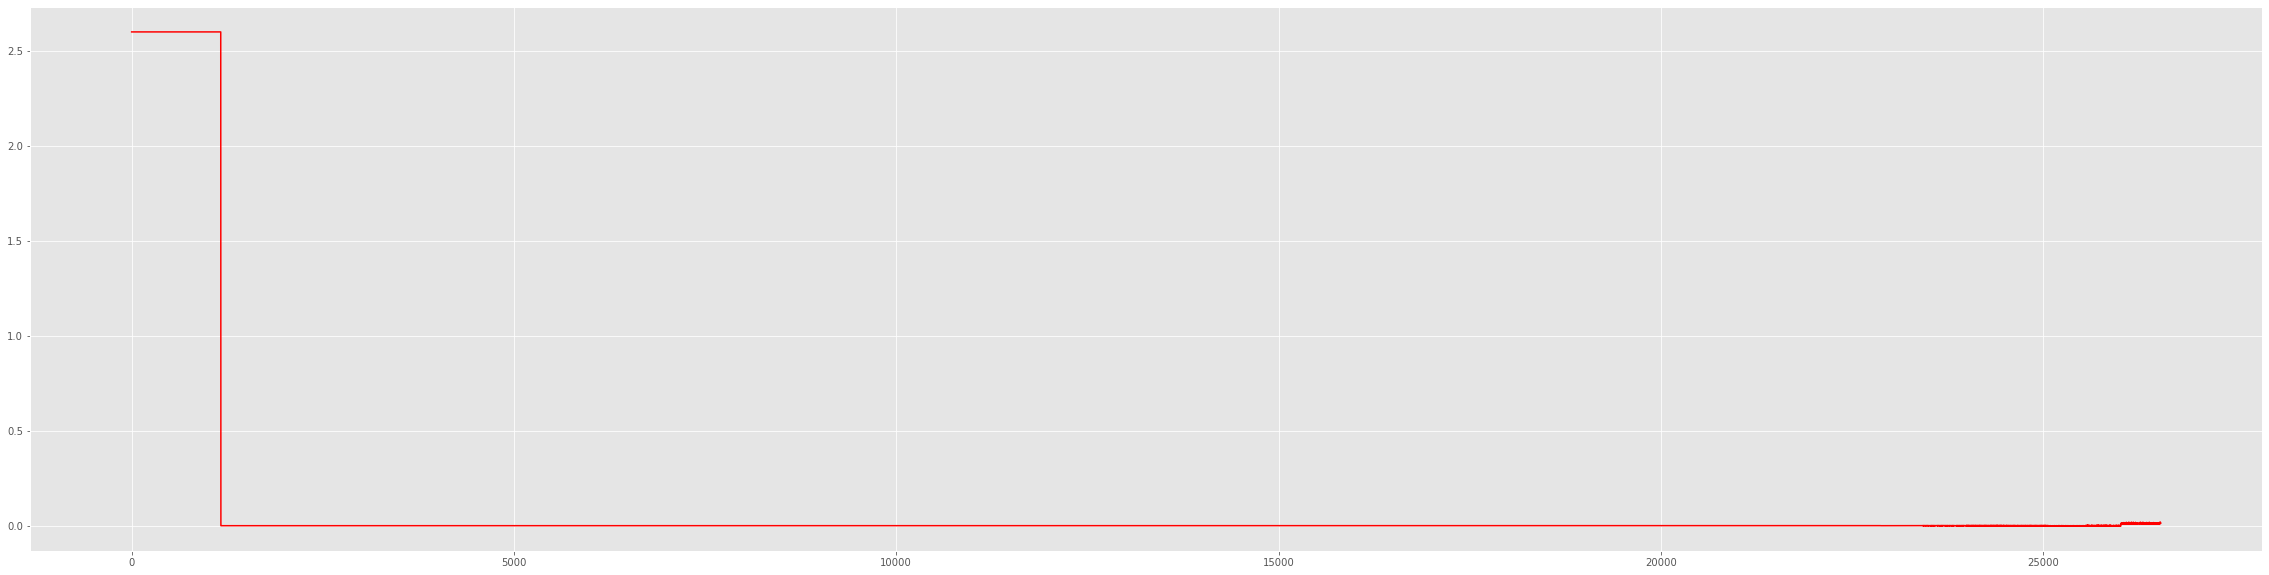

In [58]:
#x,y
plt.figure(figsize = (40 , 10))
plt.plot(submission.ID,submission.item_cnt_month, color='r', label="LSTM loss");

In [59]:
submission = pd.DataFrame({'item_cnt_month':submission_output.ravel()})
submission

,item_cnt_month
0,2.602656
1,2.602656
2,2.602656
3,2.602656
4,2.602656
...,...
26532,0.016902
26533,0.016902
26534,0.016901
26535,0.016901
